# GuestEnv Scenario Tests

This notebook runs the GuestEnv environment in five different scenarios. Each scenario logs phonemes per agent and rewards, then plots the results.

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))
from src.env.env_gym import GuestEnv

In [2]:
def run_env(env, actions, steps=100, seed=42):
    obs, info = env.reset(seed=seed)
    phonemes, rewards = [], []
    for i in range(steps):
        act = actions[i] if i < len(actions) else actions[-1]
        obs, reward, terminated, truncated, info = env.step(act)
        phonemes.append(info['phoneme'].copy())
        rewards.append(reward)
        if terminated or truncated:
            break
    return np.array(phonemes), np.array(rewards)

def plot_results(phonemes, rewards, title):
    steps = np.arange(len(rewards))
    plt.figure(figsize=(9,4))
    for a in range(phonemes.shape[1]):
        plt.plot(steps, phonemes[:, a], label=f'Agent {a}')
    plt.xlabel('Step'); plt.ylabel('Phonemes'); plt.title(title + ' - Phonemes')
    plt.legend(); plt.grid(True); plt.show()
    plt.figure(figsize=(9,4))
    plt.plot(steps, rewards, label='Reward')
    plt.xlabel('Step'); plt.ylabel('Reward'); plt.title(title + ' - Reward')
    plt.grid(True); plt.show()

## Scenario 1: Baseline
No guest actions are taken.

2025-10-05 01:01:13 | INFO | self.energy=array([0.0386978 , 0.27555138, 0.44343917])
2025-10-05T01:01:13.277335+0300 self.energy=array([0.0386978 , 0.27555138, 0.44343917])


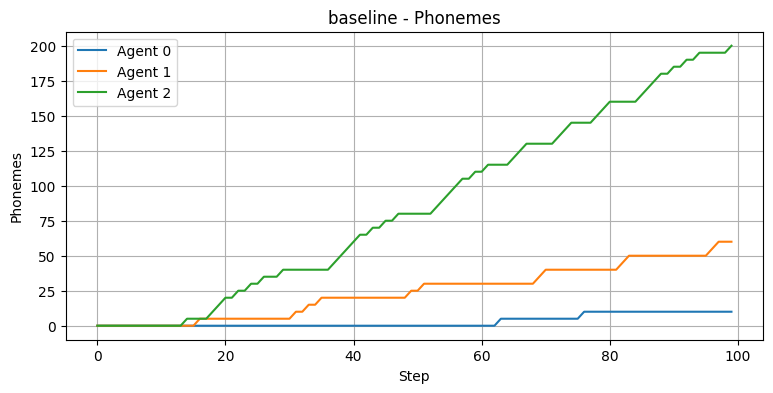

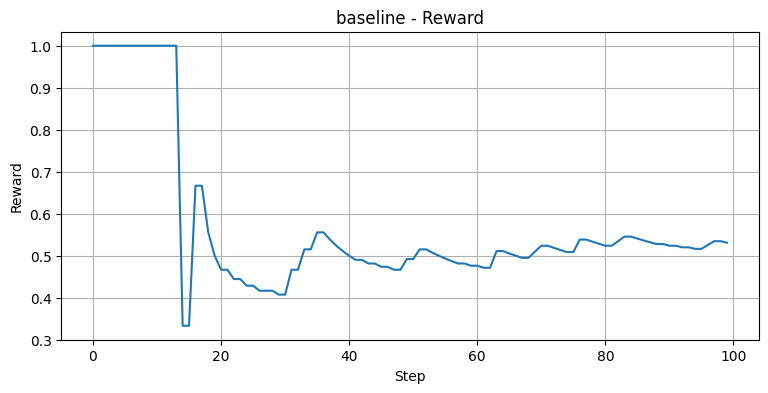

In [3]:
env = GuestEnv(max_steps=100, reward_shaping=False)

env.agent_params[0].update({  # quiet analyst
    "min_energy_to_speak": 0.20,
    "energy_gain": 0.002,
    "energy_decay": 0.08,
    "max_speaking_time": 6,
    "phonemes_per_step": 5,
})

env.agent_params[1].update({  # balanced mediator
    "min_energy_to_speak": 0.55,
    "energy_gain": 0.010,
    "energy_decay": 0.05,
    "max_speaking_time": 8,
    "phonemes_per_step": 5,
})

env.agent_params[2].update({  # energetic storyteller
    "min_energy_to_speak": 0.85,
    "energy_gain": 0.028,
    "energy_decay": 0.03,
    "max_speaking_time": 12,
    "phonemes_per_step": 5,
})
actions = [0]*100

p, r = run_env(env, actions)
plot_results(p, r, 'baseline')

In [4]:
# env = GuestEnv(max_steps=200, reward_shaping=False)
# env.agent_params[0].update({'min_energy_to_speak':0.6,'energy_gain':0.01,'energy_decay':0.15,'max_speaking_time':2,'phonemes_per_step':1})
# env.agent_params[1].update({'min_energy_to_speak':0.3,'energy_gain':0.05,'energy_decay':0.10,'max_speaking_time':5,'phonemes_per_step':2})
# env.agent_params[2].update({'min_energy_to_speak':0.1,'energy_gain':0.10,'energy_decay':0.05,'max_speaking_time':8,'phonemes_per_step':4})
# actions = [4]*200